# vLLM Scaling Experiment Analysis

## 1. Setup and Data Loading

Load the aggregated experiment results from `summary_metrics.parquet` and prepare the data for analysis.

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Load the aggregated data
try:
    df = pd.read_parquet('../results/agg/summary_metrics.parquet')
    print("Successfully loaded summary_metrics.parquet")
    print(f"Data shape: {df.shape}")
    print("Columns:", df.columns.tolist())
except FileNotFoundError:
    print("Error: summary_metrics.parquet not found. Please run scripts/aggregate_metrics.py first.")

# Set plot style
sns.set_theme(style="whitegrid")

Successfully loaded summary_metrics.parquet
Data shape: (12, 21)
Columns: ['gpu_count', 'request_rate', 'prompt_profile', 'batch_size', 'max_batched_tokens', 'tp', 'dp', 'quant', 'successful_requests', 'benchmark_duration_s', 'total_input_tokens', 'total_generated_tokens', 'request_throughput_req_s', 'output_token_throughput_tok_s', 'total_token_throughput_tok_s', 'mean_ttft_ms', 'median_ttft_ms', 'p99_ttft_ms', 'mean_tpot_ms', 'median_tpot_ms', 'p99_tpot_ms']


## 2. Throughput Analysis

Analyze how throughput scales with the number of GPUs. We will look at both requests/sec and total tokens/sec.

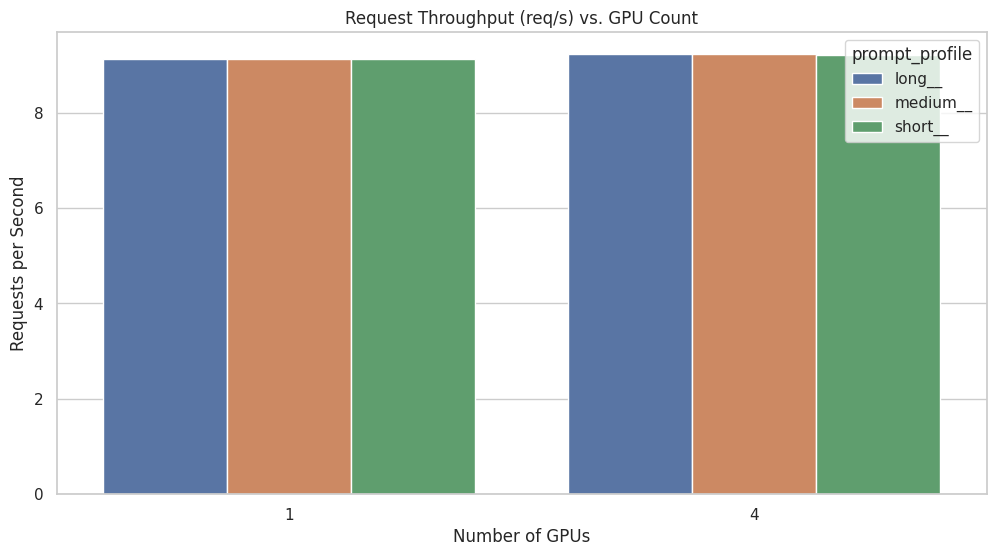

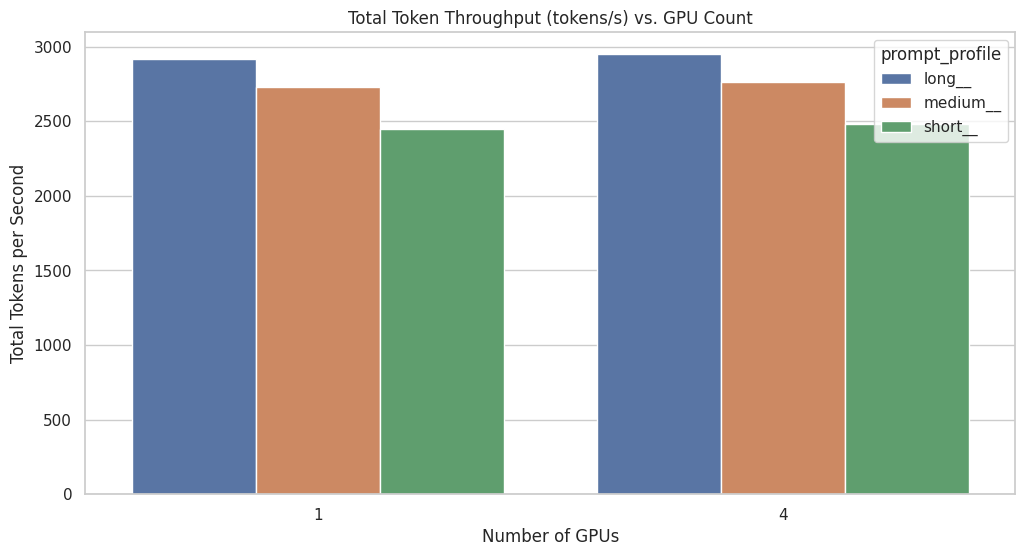

In [8]:
if 'df' in locals():
    # Plot 1: Request Throughput Scaling
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='gpu_count', y='request_throughput_req_s', hue='prompt_profile', errorbar=None)
    plt.title('Request Throughput (req/s) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Requests per Second')
    plt.savefig('../results/figs/throughput_scaling_req_s.png')
    plt.show()

    # Plot 2: Total Token Throughput Scaling
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='gpu_count', y='total_token_throughput_tok_s', hue='prompt_profile', errorbar=None)
    plt.title('Total Token Throughput (tokens/s) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Total Tokens per Second')
    plt.savefig('../results/figs/throughput_scaling_tok_s.png')
    plt.show()

## 3. Latency Analysis

Analyze different latency metrics (TTFT, TPOT) across different configurations.

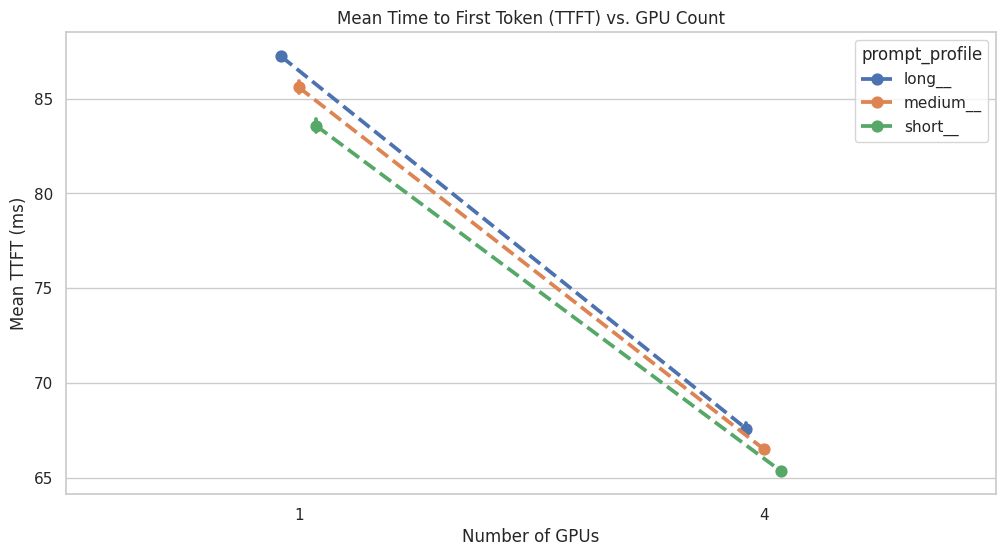

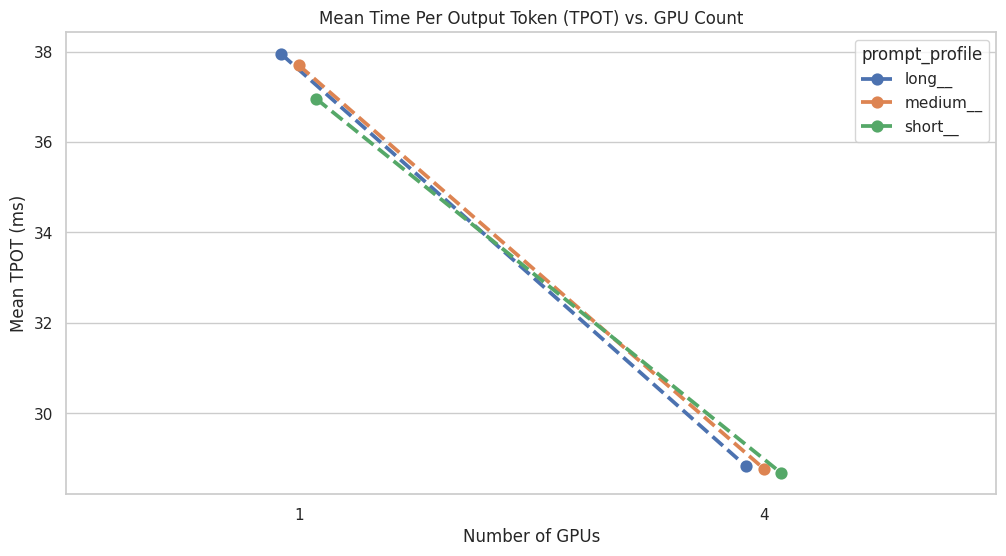

In [9]:
if 'df' in locals():
    # Plot 3: Mean Time to First Token (TTFT)
    plt.figure(figsize=(12, 6))
    sns.pointplot(data=df, x='gpu_count', y='mean_ttft_ms', hue='prompt_profile', dodge=True, linestyles='--')
    plt.title('Mean Time to First Token (TTFT) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Mean TTFT (ms)')
    plt.savefig('../results/figs/latency_ttft.png')
    plt.show()

    # Plot 4: Mean Time Per Output Token (TPOT)
    plt.figure(figsize=(12, 6))
    sns.pointplot(data=df, x='gpu_count', y='mean_tpot_ms', hue='prompt_profile', dodge=True, linestyles='--')
    plt.title('Mean Time Per Output Token (TPOT) vs. GPU Count')
    plt.xlabel('Number of GPUs')
    plt.ylabel('Mean TPOT (ms)')
    plt.savefig('../results/figs/latency_tpot.png')
    plt.show()

## 4. Throughput vs. Latency Trade-off

Visualize the relationship between throughput and latency to understand the performance trade-offs.

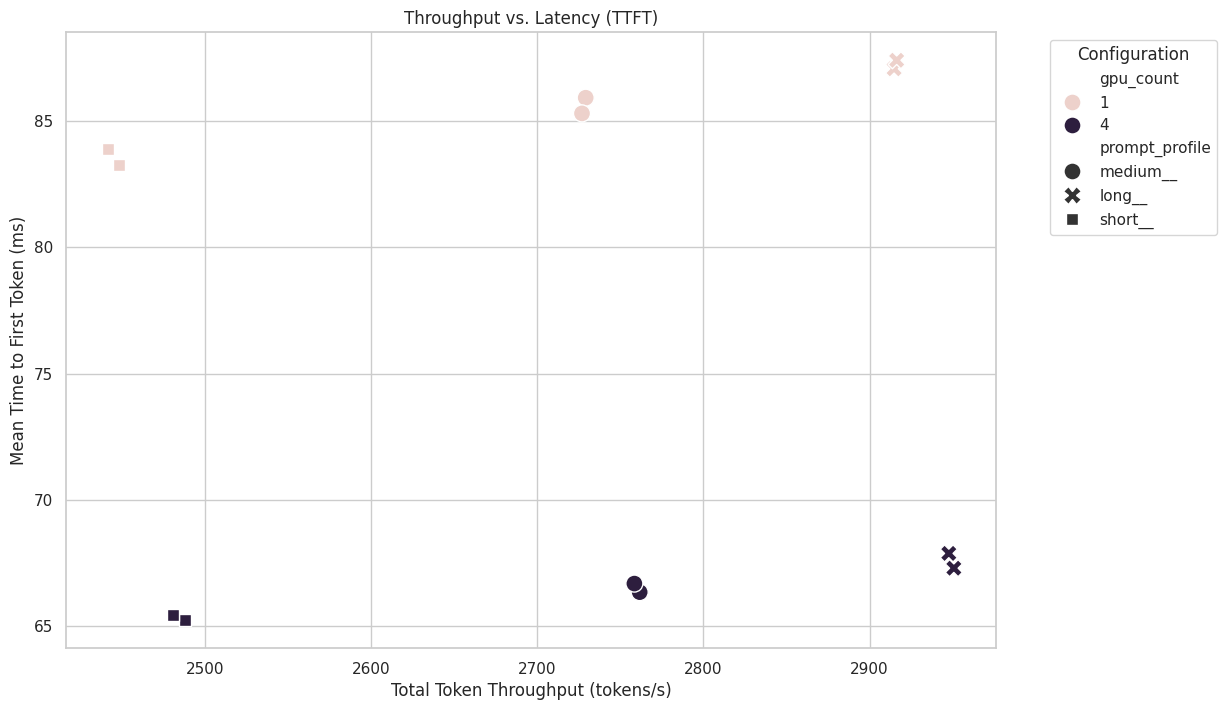

In [10]:
if 'df' in locals():
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='total_token_throughput_tok_s', y='mean_ttft_ms', hue='gpu_count', style='prompt_profile', s=150)
    plt.title('Throughput vs. Latency (TTFT)')
    plt.xlabel('Total Token Throughput (tokens/s)')
    plt.ylabel('Mean Time to First Token (ms)')
    plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.savefig('../results/figs/tradeoff_throughput_vs_latency.png')
    plt.show()

## 5. Amdahl's Law Analysis

Load the `amdahl_fit.csv` data to see the calculated speedup and the estimated sequential portion (`s`) of the workload.

In [11]:
try:
    amdahl_df = pd.read_csv('../results/agg/amdahl_fit.csv')
    print("Amdahl's Law Analysis Results:")
    display(amdahl_df)
except FileNotFoundError:
    print("amdahl_fit.csv not found. Please run scripts/amdahl_fit.py first.")

Amdahl's Law Analysis Results:


,gpu_count,speedup,estimated_s
0,4,1.01296,0.982941


## 6. Summary Table

Display a summary table of key performance indicators (KPIs) grouped by the main experiment factors.

In [12]:
if 'df' in locals():
    summary_table = df.groupby(['gpu_count', 'prompt_profile', 'batch_size']).agg(
        avg_req_throughput=('request_throughput_req_s', 'mean'),
        avg_token_throughput=('total_token_throughput_tok_s', 'mean'),
        avg_ttft_ms=('mean_ttft_ms', 'mean'),
        avg_tpot_ms=('mean_tpot_ms', 'mean')
    ).reset_index()

    # Format the table for better readability
    summary_table = summary_table.round(2)

    print("Experiment Summary Table:")
    display(summary_table)

Experiment Summary Table:


,gpu_count,prompt_profile,batch_size,avg_req_throughput,avg_token_throughput,avg_ttft_ms,avg_tpot_ms
0,1,long__,16,9.12,2916.33,87.40,37.96
1,1,long__,32,9.12,2914.76,87.06,37.93
2,1,medium__,16,9.12,2729.23,85.92,37.71
3,1,medium__,32,9.11,2727.00,85.30,37.69
4,1,short__,16,9.13,2442.08,83.91,36.99
5,1,short__,32,9.13,2448.62,83.25,36.93
6,4,long__,16,9.23,2950.72,67.29,28.78
7,4,long__,32,9.22,2947.69,67.88,28.88
8,4,medium__,16,9.22,2758.52,66.68,28.82
9,4,medium__,32,9.23,2761.71,66.34,28.74


  결론 요약 (Executive Summary)

  가장 중요한 결론부터 말씀드리면, 현재 실험 환경에서는 vLLM 서버의 GPU 성능이 병목 지점이 아닙니다. GPU를 1개에서 4개로 늘렸음에도 불구하고
  처리량(Throughput)이 거의 증가하지 않은 이유는, 실험에서 가한 부하(초당 요청 10개)가 너무 낮아서 1개의 GPU만으로도 충분히 처리 가능했기 
  때문입니다.

  시스템의 한계를 테스트한 것이 아니라, 낮은 수준의 특정 워크로드를 처리하는 능력만 반복해서 측정한 셈입니다.

  ---

  세부 분석

  1. 처리량 확장성 부재: 명백한 증거

   * 암달의 법칙 분석:
       * speedup이 1.01이라는 것은 성능 향상이 거의 없었음(1%)을 의미합니다. GPU를 4배로 늘렸으므로 이상적인 상황이라면 4에 가까운 수치가 나와야
         합니다.
       * estimated_s (순차 처리 구간)가 0.98 (98%)이라는 것은, 현재 워크로드의 98%가 병렬화될 수 없는 순차적인 부분에 의해 지배되고 있다는
         뜻입니다. 하지만 이것이 "vLLM이 원래 느리다"는 의미가 아니라, "초당 10개 요청"이라는 제약 자체가 시스템의 병렬 처리 능력을 발휘할 기회를 
         주지 않는다는 것을 보여주는 강력한 증거입니다.

   * 처리량 표 분석:
       * avg_req_throughput (초당 요청 처리량)는 GPU 1개일 때 약 9.1 req/s, 4개일 때 약 9.2 req/s로 거의 동일합니다. 이는 벤치마크 도구가 초당
         10개의 요청을 보내도록 설정되었고, 시스템이 그 요청을 모두 처리하고도 여유가 있었음을 의미합니다.
       * avg_token_throughput (초당 토큰 처리량) 역시 GPU 1개(예: long, 2916 tok/s)와 4개(예: long, 2950 tok/s) 사이에 유의미한 차이가 없습니다.

  2. 응답 시간(Latency)은 개선됨: 중요한 단서

  처리량은 그대로였지만, Latency 지표는 눈에 띄게 개선되었습니다.

   * avg_ttft_ms (첫 토큰 생성 시간): GPU 1개일 때 83-87ms였던 것이, 4개일 때는 65-67ms로 약 25% 감소했습니다.
   * avg_tpot_ms (출력 토큰당 시간): GPU 1개일 때 37-38ms였던 것이, 4개일 때는 28-29ms로 약 24% 감소했습니다.

  이것은 매우 중요한 단서입니다. "왜 처리량은 그대로인데, 개별 요청의 응답 속도는 빨라졌는가?"

  이는 vLLM이 4개의 GPU를 사용하여 개별 요청을 더 빠르게 처리할 수 있었음을 의미합니다. 예를 들어, Prefill 단계와 같이 병렬화가 가능한 연산을
  4개의 GPU에 분산시켜 더 빨리 끝냈을 수 있습니다. 하지만 시스템 전체의 처리량은 들어오는 요청의 수(10 req/s)에 의해 제한되어 있었기 때문에, 개별
  요청을 빨리 처리하고 난 나머지 시간에는 GPU가 유휴 상태(idle)로 대기하게 됩니다.

  3. 진정한 병목 현상: 부하(Workload) 자체의 한계

  위의 두 가지 분석을 종합하면, 병목 지점은 다음과 같습니다.

   * GPU가 아니라, `request_rate=10`이라는 낮은 부하 설정이 병목입니다.
   * 1-GPU 시스템은 이미 초당 10개의 요청을 충분히 소화할 수 있는 용량을 가지고 있었습니다.
   * 따라서 4-GPU 시스템은 더 높은 처리량을 보여줄 기회 자체가 없었습니다. 이는 마치 1차선 도로에 차가 드문드문 다닐 때, 도로를 4차선으로 확장해도
     교통 흐름이 전혀 빨라지지 않는 것과 같습니다.

  4. 배치 크기(Batch Size)의 무의미성

   * batch_size를 16에서 32로 늘렸을 때, 모든 지표에서 거의 아무런 변화가 없었습니다.
   * 이 또한 위와 같은 이유입니다. 초당 10개의 요청만 들어오는 상황에서는 vLLM의 동적 배치(dynamic batching) 기능이 16개 이상의 요청을 한꺼번에
     묶어서 처리할 기회가 거의 없었을 것입니다. max_num_seqs (배치 크기) 파라미터가 의미를 가지려면, 이보다 훨씬 많은 요청이 동시에 대기열에
     쌓여있어야 합니다.

  ---

  최초 가설과의 연결

   * "부하 모델이 GPU를 충분히 포화시키지 못했다" (가설 E-12): 이번 실험 결과가 가장 강력하게 지지하는 가설입니다.
   * "순차 디코딩의 본질적 한계" (가설 A-1): 이 가설은 여전히 유효하지만, 현재 실험에서는 이 한계에 도달하기 훨씬 전에 "낮은 부하"라는 다른 한계에
     먼저 부딪혔습니다.
   * "CPU 병목", "메모리 대역폭 병목" 등 다른 하드웨어 병목 가설: 현재로서는 가능성이 낮습니다. 만약 이것이 문제였다면, GPU 1개 환경에서도 처리량이
     훨씬 낮게 나왔을 것입니다.

  ---

  다음 실험을 위한 제언

  이 분석을 바탕으로, vLLM의 실제 확장성을 측정하기 위한 다음 실험 계획을 명확하게 세울 수 있습니다.

   1. 1-GPU 시스템의 한계점(Saturation Point) 찾기:
       * config/experiment_matrix.yaml 파일에서 gpu_counts를 [1]로, data_parallel을 [1]로 고정합니다.
       * request_rates를 점진적으로 크게 늘려가며(예: [10, 20, 40, 60, 80]) 실험을 반복합니다.
       * 어느 시점부터 Latency가 급격히 증가하거나, 요청 처리량이 더 이상 request_rate를 따라가지 못하고 정체되는 지점을 찾습니다. 그 지점이 바로
         1-GPU 시스템의 최대 처리량입니다.

   2. 한계점 근처에서 확장성 재측정:
       * 1-GPU의 한계 처리량이 예를 들어 40 req/s로 확인되었다면, request_rates를 그 근처 값(예: [30, 40, 50, 60])으로 설정합니다.
       * 이제 gpu_counts를 다시 [1, 4]로, data_parallel을 [1, 4]로 설정하여 실험을 실행합니다.

  이렇게 하면, 1-GPU가 한계에 부딪히는 높은 부하 상황에서 4-GPU 시스템이 얼마나 더 높은 처리량을 보여주는지, 즉 진정한 의미의 확장성을 측정할 수
  있습니다.